Can we use natural language processing on reviews to predict Airbnb scores? We will analyze 350,000 reviews on Airbnb listings to attempt to predict the components of an Airbnb score: accuracy, check in, communication, location, value, and overall score. 

Further, can our team do so in a generalizable way? We are breaking up this large dataset into thirds and working to predict our third as closely as possible...while making it generalizable and not overfit to this particular data. We will swap sets after our analysis is complete and see how closely we can predict the other portions of the file.

In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
import goslate             # language translation
from textblob import TextBlob
from collections import defaultdict 
import numpy as np
from spellchecker import SpellChecker
from enchant.checker import SpellChecker
import time
import enchant
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.probability import FreqDist
#from nltk import FreqDist
from textblob.sentiments import NaiveBayesAnalyzer
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
chunk3_reviews_df = pd.read_csv("Airbnb - Chicago/reviews_chunk3.csv")

In [3]:
chunk3_reviews_df.shape # should only be first 116772 rows, 350674 is whole data set

(116772, 6)

In [4]:
chunk3_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116772 entries, 0 to 116771
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             116772 non-null  int64 
 1   listing_id     116772 non-null  int64 
 2   date           116772 non-null  object
 3   reviewer_id    116772 non-null  int64 
 4   reviewer_name  116772 non-null  object
 5   comments       116655 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.3+ MB


Our team split 350674 dataset into thirds; my chunk of the data is rows 1 - 116838; row 0 is headers

60 rows have null values in the comments. The following code will investigate these rows. 

In [5]:
chunk3_reviews_df[chunk3_reviews_df['comments'].isnull()]

,id,listing_id,date,reviewer_id,reviewer_name,comments
45,340000166,21784716,10/22/2018,90994143,Leslie,NaN
2465,319152885,22036047,9/5/2018,211110773,Алексей,NaN
3514,243938236,22111059,3/17/2018,56160906,Harry,NaN
4261,444949270,22208324,4/28/2019,160851961,Ronald,NaN
5624,276092245,22371480,6/12/2018,161005644,Brian,NaN
...,...,...,...,...,...,...
111044,517797055,36796742,8/25/2019,154469698,Michael,NaN
113027,528253935,37540495,9/12/2019,61522545,Matt,NaN
115590,543478326,38707430,10/7/2019,233870316,Miguel,NaN
115641,563057071,38750112,11/11/2019,235077243,Herna,NaN


In [6]:
null_df = chunk3_reviews_df[chunk3_reviews_df['comments'].isnull()] # copy nulls values to their own dataframe

In [7]:
null_df.listing_id.value_counts() # how many reviews are missing for each listing id

28833234    2
23679235    2
23442534    2
23672099    2
31596600    1
           ..
26256556    1
27490479    1
29685513    1
32471734    1
22036047    1
Name: listing_id, Length: 113, dtype: int64

In [8]:
null_ids = null_df.listing_id.unique()

In [9]:
chunk3_reviews_df.listing_id.value_counts()

23548614    288
28538337    284
25169068    265
21980644    257
23561187    212
           ... 
23869281      1
38102525      1
35518297      1
38977789      1
30529967      1
Name: listing_id, Length: 4482, dtype: int64

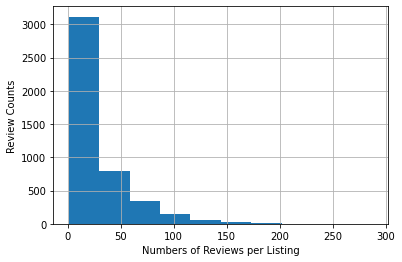

In [10]:
histo = chunk3_reviews_df.listing_id.value_counts().hist()
x= histo.set_xlabel("Numbers of Reviews per Listing")
y = histo.set_ylabel("Review Counts")

The majority of reviews have between 0-75 reviews, with very few listings with greater than 300 reviews. 

The max number of null reviews per listing is 3. While that is significant for some listings, there is no way to recover the data. Therefore, all rows with missing comments will be dropped. 

In [11]:
chunk3_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116772 entries, 0 to 116771
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             116772 non-null  int64 
 1   listing_id     116772 non-null  int64 
 2   date           116772 non-null  object
 3   reviewer_id    116772 non-null  int64 
 4   reviewer_name  116772 non-null  object
 5   comments       116655 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.3+ MB


In [12]:
chunk3_reviews_df.dropna(inplace=True) # drops rows with any NaNs

In [13]:
chunk3_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116655 entries, 0 to 116771
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             116655 non-null  int64 
 1   listing_id     116655 non-null  int64 
 2   date           116655 non-null  object
 3   reviewer_id    116655 non-null  int64 
 4   reviewer_name  116655 non-null  object
 5   comments       116655 non-null  object
dtypes: int64(3), object(3)
memory usage: 6.2+ MB


No other missing data, 116655 reviews remain

In [14]:
chunk3_reviews_df

,id,listing_id,date,reviewer_id,reviewer_name,comments
0,215412883,21784716,11/29/2017,13109574,Justin,(Website hidden by Airbnb) where do I begin? L...
1,217997495,21784716,12/10/2017,46340737,Zac,"Awesome place, great neighborhood. It's right ..."
2,219458638,21784716,12/17/2017,157831350,Mileena,"The host, area and the unit is perfect!"
3,220282092,21784716,12/21/2017,39022353,Rui,Really nice and warm house.
4,221492695,21784716,12/26/2017,58270043,Estephanie,I thought finding the place would be hard at f...
...,...,...,...,...,...,...
116767,566725519,40047071,11/20/2019,308801048,Susana,The host canceled this reservation 8 days befo...
116768,564740110,40097723,11/16/2019,309519273,Ty'Tiana,Her air bnb is perfect for a small gathering/g...
116769,565723593,40097723,11/17/2019,77335228,Lauren,"Place was really clean, absolutely HUGE and th..."
116770,566472610,40133168,11/19/2019,1768197,Peggy,Maggie's place was very clean and she was very...


In [15]:
# set up dictionary to hold sentence tokens that pertain to each part of review
def def_value(): 
    return []
      
# Defining the dict 
listing_comments = defaultdict(def_value) 

In [16]:
np.set_printoptions(suppress=True) # suppress scientific notation from np
unique_listingIds = np.unique(chunk3_reviews_df.listing_id.values)

In [17]:
len(unique_listingIds)

4482

In [18]:
pd.DataFrame(unique_listingIds).to_csv("unique_listing_ids_chunk3.csv")

In [19]:
for listingId in unique_listingIds: # create default dicts for all the listing ids
    listing_comments[listingId] = defaultdict(def_value)

This section creates sections to divide each review into the categories by which the reviews are grouped. There are six review categories: accuracy, check in, communication, location, value, and cleanliness with a 1 -10 scale. There is an overall review category that is on a 100 point scale.

In [20]:
accuracy_words=["accuracy", "truth", "inaccurate", "correct", "reality", "untrue", "describe", "described","looks",\
                "pictures","pictured","description","photos","advertised"]
checkin_words= ["check in", "met us", "keys","check-in"]
communication_words=["communication","contact","response","answer","reply","communicate","messages", "message","responsive",\
                    "helpful","respond","communicating","communicates","service"]
location_words=["location","site","locale","locality","close","far","spot","bars","train","restaurants","shopping",\
                "dining","safe","dangerous","distance", "proximity", "across","walk","metro","located",\
                "best places of chicago","neighborhood","downtown","brown line","pink line","el station","blue line",\
                "red line","purple line"]
value_words=["value","expensive","cheap","price","budget","fortune","rate", "very near","pricing"]
cleanliness_words = ["clean","dirty","fresh","filty","spotless","immaculate", "cleanliness","tidy","cockroach","sparkling"]


This section does a bit of preprocessing by lowercasing all the text. It then groups the listings into the 6 categories. If the text doesn't fall into these categories, it is grouped into the 'unspecified' category. If a review is in a foreign language, it will also be grouped in that category to be translated and sorted into its correct category at a later point. The foreign language processing is very slow due to rate limits on the server on which the processing happens, so I chose not to do it on the entire set, only text that couldn't immediately be categorized.

In [21]:
for index, row in chunk3_reviews_df.iterrows():
    sentences = sent_tokenize(chunk3_reviews_df['comments'][index])
    for sentence in sentences:
        sentence = sentence.lower()  # lowercase all text
           
        if any(word in sentence for word in accuracy_words):            
            listing_comments[chunk3_reviews_df["listing_id"][index]]['accuracy'].append(sentence)
                
        elif any(word in sentence for word in checkin_words):
            listing_comments[chunk3_reviews_df["listing_id"][index]]['checkin'].append(sentence)
                
        elif any(word in sentence for word in cleanliness_words):
            listing_comments[chunk3_reviews_df["listing_id"][index]]['cleanliness'].append(sentence)
            
        elif any(word in sentence for word in communication_words):
            listing_comments[chunk3_reviews_df["listing_id"][index]]['communication'].append(sentence)
                
        elif any(word in sentence for word in value_words):
            listing_comments[chunk3_reviews_df["listing_id"][index]]['value'].append(sentence)
            
        elif any(word in sentence for word in location_words):
            listing_comments[chunk3_reviews_df["listing_id"][index]]['location'].append(sentence)                    
                                      
        else:
            listing_comments[chunk3_reviews_df["listing_id"][index]]['unspecified'].append(sentence)


In [22]:
len(listing_comments) # all sentences in listing reviews have been sorted by review category

4482

Lemmatization requires a part of speech to work correctly, otherwise all words are assumed to be nouns. When the words are tokenized, it gets tagged with a part of speech by the context. However, that part of speech is more complex than we need for our current purposes. This maps from the complex speech parts to the simpler NOUN = 'n', ADJ = 's', VERB = 'v' and ADV = 'r' that is required for the nltk lemmatizer function.

In [23]:
# Create a map between Treebank and WordNet 
# WordNet POS tags are: NOUN = 'n', ADJ = 's', VERB = 'v', ADV = 'r', ADJ_SAT = 'a'
# Descriptions (c) https://web.stanford.edu/~jurafsky/slp3/10.pdf
tag_map = {
        'CC':None, # coordin. conjunction (and, but, or)  
        'CD':wn.NOUN, # cardinal number (one, two)             
        'DT':None, # determiner (a, the)                    
        'EX':wn.ADV, # existential ‘there’ (there)           
        'FW':None, # foreign word (mea culpa)             
        'IN':wn.ADV, # preposition/sub-conj (of, in, by)   
        'JJ':wn.ADJ, # adjective (yellow)      
        'JJR':wn.ADJ, # adj., comparative (bigger)          
        'JJS':wn.ADJ, # adj., superlative (wildest)           
        'LS':None, # list item marker (1, 2, One)          
        'MD':None, # modal (can, should)                    
        'NN':wn.NOUN, # noun, sing. or mass (llama)          
        'NNS':wn.NOUN, # noun, plural (llamas)                  
        'NNP':wn.NOUN, # proper noun, sing. (IBM)              
        'NNPS':wn.NOUN, # proper noun, plural (Carolinas)
        'PDT':wn.ADJ, # predeterminer (all, both)            
        'POS':None, # possessive ending (’s )               
        'PRP':None, # personal pronoun (I, you, he)     
        'PRP$':None, # possessive pronoun (your, one’s)    
        'RB':wn.ADV, # adverb (quickly, never)            
        'RBR':wn.ADV, # adverb, comparative (faster)        
        'RBS':wn.ADV, # adverb, superlative (fastest)     
        'RP':wn.ADJ, # particle (up, off)
        'SYM':None, # symbol (+,%, &)
        'TO':None, # “to” (to)
        'UH':None, # interjection (ah, oops)
        'VB':wn.VERB, # verb base form (eat)
        'VBD':wn.VERB, # verb past tense (ate)
        'VBG':wn.VERB, # verb gerund (eating)
        'VBN':wn.VERB, # verb past participle (eaten)
        'VBP':wn.VERB, # verb non-3sg pres (eat)
        'VBZ':wn.VERB, # verb 3sg pres (eats)
        'WDT':None, # wh-determiner (which, that)
        'WP':None, # wh-pronoun (what, who)
        'WP$':None, # possessive (wh- whose)
        'WRB':None, # wh-adverb (how, where)
        '$':None, #  dollar sign ($)
        '#':None, # pound sign (#)
        '“':None, # left quote (‘ or “)
        '”':None, # right quote (’ or ”)
        '(':None, # left parenthesis ([, (, {, <)
        ')':None, # right parenthesis (], ), }, >)
        ',':None, # comma (,)
        '.':None, # sentence-final punc (. ! ?)
        ':':None # mid-sentence punc (: ; ... – -)
    }

https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/ Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

Subjectivity was increased by 1.5 for positive reviews and decreased by 0.5 for negative reviews. The logic behind this was that if a person feels strongly about a place they will use more adjectives, which are words that score higher in the subjectivity score. Based on initial results, it appeared that people's ratings were higher than then their sentiment analysis registered. This may be that people are reluctant to give poor scores despite their experience, or that it is difficult to capture the extent to which a person/group enjoyed a place based on their sentiment. 

In [24]:
def score_calculator(subjectivityscore):
    if subjectivityscore[0]>=0: # if polarity is positive, shift subjectivity score and increase overall score by that amt
        return((subjectivityscore[0]/2*10+5)+(subjectivityscore[1]+0.5)) # shift polarity scale from -1 to 1 to 1 to 10
    else: # if polarity is negative, shift subjectivity score and increase overall score by that amt
        return((subjectivityscore[0]/2*10+5)+(subjectivityscore[1]-0.5))

This is a function to normalize each set of words. It performs spell correction, removes punctuation, creates tokens out of each word, and then finally lemmatizes each word. 

In [25]:
word_list = [] # store a list of all words for later FreqDist, wordcloud

In [26]:
def process_listing_text(listing_dict):
    processed_listing=[]
    for sentence in listing_dict:
        sentence = str(TextBlob(sentence).correct()) # use TextBlob spelling correction
        sentence = re.sub('[^a-zA-Z\s\'\`]', "", sentence) # remove punctuation from sentences        
            
        tokens = word_tokenize(sentence) # Generate list of tokens
        tokens_pos = pos_tag(tokens) 
        tok = ""
        for token in tokens_pos:
            if token != "''" and token[1] != "''" and token[1] != '``':
                word_list.append(token[0])        # save all words for FreqDist and WordCloud            
                if tag_map[token[1]] == wn.NOUN or tag_map[token[1]] == None:
                    tok = 'n'
                elif tag_map[token[1]] == wn.VERB:
                    tok = 'v'
                elif tag_map[token[1]] == wn.ADJ:
                    tok = 's'
                elif tag_map[token[1]] == wn.ADV:
                    tok = 'r'
                processed_listing.append(lemmatizer.lemmatize(token[0],tok))
            processed_listing.append(token[0])
    return(processed_listing)

Stopwords are the most common words in a language. When analyzing text, they generally do not add value. Therefore, prior to analysis, the stopwords are removed. 

In [27]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

This section goes through the words in the unspecified 'bucket'. It checks the language of every sentence and if in a different language, the sentence is translated. They sentences are then regrouped into the different buckets. This is done later in the processing because it is quite time consuming and a very small percentage of the reviews are in a different language.

In [28]:
translate_dict=defaultdict(def_value)
for ids in unique_listingIds:
    for sentence in listing_comments[ids]['unspecified']:
        if len(sentence) > 2:   # must have 3+ characters in string for lang detect
            blob = TextBlob(sentence) 
            if blob.detect_language() != 'en': # translate to english
                translate_dict[ids].append(sentence)
        time.sleep(5)

In [29]:
translatedtoenglish_dict=defaultdict(def_value)
for ids in translate_dict:
    for sentence in translate_dict[ids]:  
        sentence = sentence[:-1] # remove period from sentences                
        try:
            sentence = blob.translate(to= 'en')
            translatedtoenglish_dict[ids].append(sentence)        
            print(sentence)
        except:
            print(sentence + " not translated")            
        time.sleep(5)  # avoid rate limit in TextBlob             
            

Call the text processing function on the unspecified text

In [30]:
unspecified_wordbag_bylisting = defaultdict(def_value) 
for ids in unique_listingIds:
    unspecified_wordbag_bylisting[ids] = process_listing_text(listing_comments[ids]['unspecified'])

In [31]:
len(unspecified_wordbag_bylisting)

4482

In [32]:
filtered_unspecified_bylisting = defaultdict(def_value)
ss_unspec_bylisting=defaultdict(def_value)
unspecified_score=defaultdict(def_value)
                             
for id in unspecified_wordbag_bylisting:
    filtered_unspecified_bylisting[id] = [w for w in unspecified_wordbag_bylisting[id] if not w in stop_words]       

for ind in filtered_unspecified_bylisting: # get the sentiment on all words in the list per listing id
    ss_unspec_bylisting[ind] = TextBlob(" ".join(filtered_unspecified_bylisting[ind])).sentiment 

for ind in ss_unspec_bylisting:
    unspecified_score[ind] = score_calculator(ss_unspec_bylisting[ind])

Get resulting score for text in unspecified group by listing id

In [33]:
unspecified_score

defaultdict(<function __main__.def_value()>,
            {21784716: 7.604166034753619,
             21785655: 7.833333333333335,
             21788299: 8.430909090909092,
             21808592: 7.899501057082452,
             21810955: 8.376666666666667,
             21811012: 8.5,
             21812384: 7.590384615384616,
             21814029: 7.634053555445958,
             21817363: 8.137424490828247,
             21838090: 8.70892857142857,
             21839421: 8.092041359794605,
             21846991: 8.144620193975593,
             21856463: 8.312459613557174,
             21860008: 7.328048780487805,
             21862111: 8.26124883732315,
             21862235: 8.072829608553988,
             21868450: 7.716666666666667,
             21868975: 7.302280497280496,
             21878178: 7.627236352444108,
             21879603: 8.037364631053952,
             21886537: 8.003862204814586,
             21890842: 8.108301677632713,
             21891700: 8.716156462585033,
     

Moving onto Accuracy group

In [128]:
accuracy_wordbag_bylisting = defaultdict(def_value) 
for ids in unique_listingIds:
    accuracy_wordbag_bylisting[ids] = process_listing_text(listing_comments[ids]['accuracy'])  

In [35]:
len(accuracy_wordbag_bylisting)

4482

In [36]:
 filtered_accuracy_bylisting = defaultdict(def_value)

In [37]:
for id in accuracy_wordbag_bylisting:
    filtered_accuracy_bylisting[id] = [w for w in accuracy_wordbag_bylisting[id] if not w in stop_words]  

In [40]:
for ind in filtered_accuracy_bylisting:
    fd = FreqDist(filtered_accuracy_bylisting[ind])

In [41]:
ss_acc_bylisting=defaultdict(def_value)
accuracy_score=defaultdict(def_value)

In [42]:
for ind in filtered_accuracy_bylisting: # get the sentiment on all words in the list per listing id
    ss_acc_bylisting[ind] = TextBlob(" ".join(filtered_accuracy_bylisting[ind])).sentiment 

In [43]:
for ind in ss_acc_bylisting:
    accuracy_score[ind] = score_calculator(ss_acc_bylisting[ind])

In [44]:
accuracy_score

defaultdict(<function __main__.def_value()>,
            {21784716: 8.166666666666668,
             21785655: 5.5,
             21788299: 8.152380952380952,
             21808592: 3.65,
             21810955: 6.5,
             21811012: 5.5,
             21812384: 5.5,
             21814029: 8.873333333333333,
             21817363: 7.881428571428572,
             21838090: 5.5,
             21839421: 5.5,
             21846991: 8.493693693693693,
             21856463: 8.13015873015873,
             21860008: 5.5,
             21862111: 8.077777777777778,
             21862235: 9.02962962962963,
             21868450: 5.5,
             21868975: 6.866666666666667,
             21878178: 7.974166666666668,
             21879603: 9.011805555555556,
             21886537: 4.5625,
             21890842: 7.772093023255815,
             21891700: 5.5,
             21893203: 8.660416666666666,
             21894548: 8.540333333333333,
             21900672: 7.6000000000000005,
             2

Analyze Check In Score

In [45]:
checkin_bylisting = defaultdict(def_value)  
filtered_checkin_bylisting = defaultdict(def_value)  
ss_checkin_bylisting=defaultdict(def_value)
checkin_score=defaultdict(def_value)

In [46]:
for ids in unique_listingIds:
    checkin_bylisting[ids] = process_listing_text(listing_comments[ids]['checkin'])                                                                                                                 

In [47]:
for ids in checkin_bylisting:
    filtered_checkin_bylisting[ids] = [w for w in checkin_bylisting[ids] if not w in stop_words]       

In [48]:
for ind in filtered_checkin_bylisting: # get the sentiment on all words in the list per listing id
    ss_checkin_bylisting[ind] = TextBlob(" ".join(filtered_checkin_bylisting[ind])).sentiment 

In [50]:
for ind in ss_checkin_bylisting:
    checkin_score[ind] = score_calculator(ss_checkin_bylisting[ind])

checkin_score         

defaultdict(<function __main__.def_value()>,
            {21784716: 7.441441441441441,
             21785655: 5.5,
             21788299: 5.5,
             21808592: 7.943386243386243,
             21810955: 5.5,
             21811012: 5.5,
             21812384: 5.5,
             21814029: 6.913537549407115,
             21817363: 7.842113095238096,
             21838090: 5.5,
             21839421: 7.932142857142857,
             21846991: 8.104395604395604,
             21856463: 5.98,
             21860008: 9.416666666666666,
             21862111: 6.595238095238095,
             21862235: 7.306623931623932,
             21868450: 5.5,
             21868975: 8.116216216216216,
             21878178: 8.620833333333334,
             21879603: 7.894791666666666,
             21886537: 7.905,
             21890842: 7.735858961640213,
             21891700: 5.5,
             21893203: 10.083333333333332,
             21894548: 8.06141975308642,
             21900672: 8.17106227106227,
 

Analyze Cleanliness Group

In [51]:
cleanliness_bylisting = defaultdict(def_value)  
filtered_cleanliness_bylisting = defaultdict(def_value)  
ss_clean_bylisting=defaultdict(def_value)
cleanliness_score=defaultdict(def_value)

In [52]:
#listing_comments['listing_id']['index']['cleanliness']
for ids in unique_listingIds:
    cleanliness_bylisting[ids] = process_listing_text(listing_comments[ids]['cleanliness'])               

In [53]:
for id in unspecified_wordbag_bylisting:
    filtered_cleanliness_bylisting[id] = [w for w in cleanliness_bylisting[id] if not w in stop_words]       

for ind in filtered_cleanliness_bylisting: # get the sentiment on all words in the list per listing id
    ss_clean_bylisting[ind] = TextBlob(" ".join(filtered_cleanliness_bylisting[ind])).sentiment 

for ind in ss_clean_bylisting:
    cleanliness_score[ind] = score_calculator(ss_clean_bylisting[ind])

cleanliness_score   

defaultdict(<function __main__.def_value()>,
            {21784716: 8.45169172932331,
             21785655: 5.5,
             21788299: 9.13,
             21808592: 7.854730983302413,
             21810955: 7.940952380952382,
             21811012: 9.608333333333334,
             21812384: 5.5,
             21814029: 8.685185185185185,
             21817363: 8.397938144329894,
             21838090: 9.141666666666667,
             21839421: 8.04809027777778,
             21846991: 8.11701073492981,
             21856463: 8.170430107526881,
             21860008: 8.07927536231884,
             21862111: 7.958373015873017,
             21862235: 8.483365633074936,
             21868450: 8.814814814814815,
             21868975: 7.701133786848073,
             21878178: 8.206363636363637,
             21879603: 8.346226392654962,
             21886537: 7.933566433566433,
             21890842: 8.152638058213707,
             21891700: 5.5,
             21893203: 7.869892473118279,
      

Analyze Communication Group

In [54]:
comm_bylisting = defaultdict(def_value)  
filtered_comm_bylisting = defaultdict(def_value)  
ss_comm_bylisting=defaultdict(def_value)
comm_score=defaultdict(def_value)

In [55]:
#listing_comments['listing_id']['index']['communication']
for ids in unique_listingIds:
    comm_bylisting[ids] = process_listing_text(listing_comments[ids]['communication'])               

In [56]:
for id in unspecified_wordbag_bylisting:
    filtered_comm_bylisting[id] = [w for w in comm_bylisting[id] if not w in stop_words]       

for ind in filtered_unspecified_bylisting: # get the sentiment on all words in the list per listing id
    ss_comm_bylisting[ind] = TextBlob(" ".join(filtered_comm_bylisting[ind])).sentiment 

for ind in ss_unspec_bylisting:
    comm_score[ind] = score_calculator(ss_comm_bylisting[ind])

comm_score

defaultdict(<function __main__.def_value()>,
            {21784716: 7.650843881856541,
             21785655: 5.5,
             21788299: 8.616496598639456,
             21808592: 8.107407407407408,
             21810955: 8.638095238095238,
             21811012: 5.5,
             21812384: 4.875,
             21814029: 8.802777777777777,
             21817363: 8.4619746162928,
             21838090: 5.5,
             21839421: 8.608933933933933,
             21846991: 8.173781673881674,
             21856463: 8.054166666666667,
             21860008: 11.5,
             21862111: 8.053496168582376,
             21862235: 7.913361462728551,
             21868450: 5.5,
             21868975: 7.81870429819868,
             21878178: 7.899929971988796,
             21879603: 8.569937275985664,
             21886537: 8.345833333333333,
             21890842: 8.38053902116402,
             21891700: 5.5,
             21893203: 8.904117647058824,
             21894548: 7.977751572327043,
    

Analyze Value Group

In [57]:
value_bylisting = defaultdict(def_value)  
filtered_value_bylisting = defaultdict(def_value)  
ss_value_bylisting=defaultdict(def_value)
value_score=defaultdict(def_value)

In [58]:
#listing_comments['listing_id']['index']['value']
for ids in unique_listingIds:
    value_bylisting[ids] = process_listing_text(listing_comments[ids]['value'])               

In [59]:
for id in value_bylisting:
    filtered_value_bylisting[id] = [w for w in value_bylisting[id] if not w in stop_words]       

for ind in filtered_value_bylisting: # get the sentiment on all words in the list per listing id
    ss_value_bylisting[ind] = TextBlob(" ".join(filtered_value_bylisting[ind])).sentiment 

for ind in ss_unspec_bylisting:
    value_score[ind] = score_calculator(ss_value_bylisting[ind])

value_score

defaultdict(<function __main__.def_value()>,
            {21784716: 8.238776443682104,
             21785655: 5.5,
             21788299: 10.25,
             21808592: 8.78732638888889,
             21810955: 8.540000000000001,
             21811012: 5.5,
             21812384: 5.5,
             21814029: 7.348571428571429,
             21817363: 8.444017094017093,
             21838090: 5.5,
             21839421: 8.2,
             21846991: 8.438333333333334,
             21856463: 10.25,
             21860008: 7.1,
             21862111: 8.779090909090908,
             21862235: 8.366666666666667,
             21868450: 10.75,
             21868975: 8.898113207547171,
             21878178: 8.524921630094044,
             21879603: 9.000000000000002,
             21886537: 7.5,
             21890842: 9.043010752688172,
             21891700: 5.5,
             21893203: 5.5,
             21894548: 9.32,
             21900672: 9.085714285714285,
             21901126: 10.25,
         

Location Analysis

In [60]:
location_bylisting = defaultdict(def_value)  
filtered_location_bylisting = defaultdict(def_value)  
ss_loc_bylisting=defaultdict(def_value)
location_score=defaultdict(def_value)

In [61]:
#listing_comments['listing_id']['index']['location']
for ids in unique_listingIds:
    location_bylisting[ids] = process_listing_text(listing_comments[ids]['location'])    

In [62]:
for id in location_bylisting:
    filtered_location_bylisting[id] = [w for w in location_bylisting[id] if not w in stop_words]       

for ind in filtered_unspecified_bylisting: # get the sentiment on all words in the list per listing id
    ss_loc_bylisting[ind] = TextBlob(" ".join(filtered_location_bylisting[ind])).sentiment 

for ind in ss_unspec_bylisting:
    location_score[ind] = score_calculator(ss_loc_bylisting[ind])

location_score

defaultdict(<function __main__.def_value()>,
            {21784716: 7.877915615500651,
             21785655: 7.716666666666667,
             21788299: 8.495000000000001,
             21808592: 7.574055555555557,
             21810955: 7.454392666157372,
             21811012: 5.5,
             21812384: 9.069230769230769,
             21814029: 8.577160997732426,
             21817363: 8.200123603709258,
             21838090: 5.5,
             21839421: 8.478186907838069,
             21846991: 8.466175579322638,
             21856463: 8.821127308066083,
             21860008: 9.147727272727272,
             21862111: 8.220739003794558,
             21862235: 8.05293844367015,
             21868450: 8.241666666666667,
             21868975: 8.498496862310814,
             21878178: 7.260069909765032,
             21879603: 8.44816023976024,
             21886537: 7.980701754385966,
             21890842: 8.698961830162876,
             21891700: 8.17142857142857,
             2189320

Combine scores into dataframe

In [63]:
dat = {'AccuracyScore_calc': accuracy_score, 'CleanScore_calc':cleanliness_score, 'CheckinScore_calc':checkin_score, 'CommScore_calc':comm_score, 'LocationScore_calc':location_score, 'ValueScore_Calc':value_score}
review_scores_df = pd.DataFrame(data=dat)

Total word list for frequency distribution

In [64]:
len(word_list)

4540328

In [65]:
filtered_word_list=[] 
filtered_word_list = [w for w in word_list if not w in stop_words]       

In [66]:
FreqDist(filtered_word_list)

FreqDist({'great': 73656, 'place': 68026, 'stay': 49078, 'location': 40051, 'clean': 37181, 'would': 26478, 'chicago': 23346, 'nice': 23343, 'apartment': 23146, 'host': 21453, ...})

In [67]:
text = ""
for word in filtered_word_list:
    if len(word)>1:
        text += word + " "

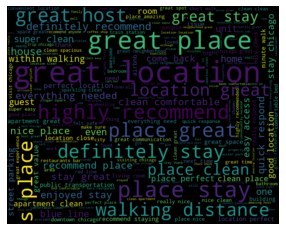

In [68]:
#% matplotlib inline
# Create and generate a word cloud image:
wordcloud = WordCloud(width=1000, height=800).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [69]:
review_scores_df.to_csv('review_scores_chunk3.csv')

Analysis of Results

In [70]:
listing_df = pd.read_csv('Airbnb - Chicago/listings.csv', header = 1)
listing_df.drop(columns=['listing_url', 'name', 'description', 'host_since', 'city', 'state', 'zipcode', 'country_code', "latitude","longitude","property_type","room_type","accommodates","bathrooms","bedrooms","security_deposit","cleaning_fee","instant_bookable","cancellation_policy"])

,id,host_id,neighbourhood,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,2384,2613,Hyde Park,100.0,10.0,10.0,10.0,10.0,10.0,10.0
1,4505,5775,Little Village,96.0,10.0,9.0,10.0,10.0,9.0,9.0
2,7126,17928,Ukrainian Village,93.0,10.0,9.0,10.0,10.0,10.0,10.0
3,9811,33004,Old Town,92.0,10.0,9.0,10.0,9.0,10.0,9.0
4,10610,2140,Hyde Park,82.0,8.0,7.0,9.0,9.0,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...
8528,40262251,2912333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8529,40263536,50413447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8530,40264107,35065108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8531,40264148,50413447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
ids = pd.read_csv('unique_listing_ids_chunk3.csv', skiprows=0, index_col=False)
ids.columns=['index','listing_id']
ids.listing_id

0       21784716
1       21785655
2       21788299
3       21808592
4       21810955
          ...   
4477    40010734
4478    40047071
4479    40097723
4480    40133168
4481    40136229
Name: listing_id, Length: 4482, dtype: int64

In [72]:
processed_listing = []
for row in listing_df.iterrows():
    if (row[1][0] in list(ids.listing_id)):
        #print(row[1])
        processed_listing.append(row[1])

In [73]:
processed_listing_df = pd.DataFrame(processed_listing)
processed_listing_df.reset_index(inplace=True)
processed_listing_df

,index,id,listing_url,name,description,host_id,host_since,neighbourhood,city,state,...,cleaning_fee,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy
0,2958,21784716,https://www.airbnb.com/rooms/21784716,3 Level Lincoln Park Townhouse with 4 Beds!,Comfortable and eclectic 3-story townhouse in ...,64473273,3/25/2016,Lincoln Park,Chicago,IL,...,$135.00,90.0,10.0,9.0,10.0,10.0,9.0,9.0,f,moderate
1,2959,21785655,https://www.airbnb.com/rooms/21785655,PRIVATE ROOM IN LAKEVIEW HEART! BOYSTOWN -WRIGLEY,Villa Stella is literally the place to be! In ...,154630260,10/15/2017,Lakeview,Chicago,IL,...,NaN,80.0,8.0,10.0,10.0,10.0,10.0,4.0,t,strict_14_with_grace_period
2,2960,21788299,https://www.airbnb.com/rooms/21788299,"Wanderlust in Wicker Park! Entire, HUGE 1 bed apt","This beautifully remodeled, modern 1 bedroom, ...",48049735,11/3/2015,Bucktown,Chicago,IL,...,$50.00,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate
3,2964,21808592,https://www.airbnb.com/rooms/21808592,"Home base 1 near O' Hare ORD, Rosemont","Clean, affordable and roomy private queen room...",158948610,11/16/2017,Jefferson Park,Chicago,IL,...,$17.00,96.0,10.0,9.0,10.0,10.0,10.0,10.0,f,moderate
4,2967,21810955,https://www.airbnb.com/rooms/21810955,Home Base 2 near O' Hare ORD and Rosemont,"Clean, affordable and roomy private queen room...",158948610,11/16/2017,Jefferson Park,Chicago,IL,...,$17.00,97.0,10.0,9.0,10.0,10.0,9.0,10.0,f,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,8419,40010734,https://www.airbnb.com/rooms/40010734,Chicago Humboldt Park Blvd 3 BR on the Park NEW,This is a NEW listing from a with help from my...,270724764,6/23/2019,Humboldt Park,Chicago,IL,...,$99.00,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate
4478,8426,40047071,https://www.airbnb.com/rooms/40047071,Beautiful South Side Chicago Style Bungalow,Beautiful well decorated South side Chicago st...,60343854,2/25/2016,Avalon Park,Chicago,IL,...,$125.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,flexible
4479,8463,40097723,https://www.airbnb.com/rooms/40097723,Brand New Up-Town Luxury 3Bed/ Modern & Bright,NaN,307246091,11/5/2019,Uptown,Chicago,IL,...,$40.00,100.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate
4480,8474,40133168,https://www.airbnb.com/rooms/40133168,Heart of Wicker Park Bright 1st Story Walk-Up!,GREAT location right in the heart of Wicker Pa...,44547774,9/19/2015,West Town/Noble Square,Chicago,IL,...,$5.00,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,moderate


In [74]:
processed_listing_df.drop(columns='index', inplace=True)
processed_listing_df
scores_df = pd.read_csv('review_scores_chunk3.csv')
scores_df.columns=("calc_id","AccuracyScore_Calc","CleanScore_Calc","CheckinScore_Calc","CommScore_Calc","LocationScore_Calc","ValueScore_Calc")
scores_df

,calc_id,AccuracyScore_Calc,CleanScore_Calc,CheckinScore_Calc,CommScore_Calc,LocationScore_Calc,ValueScore_Calc
0,21784716,8.166667,8.451692,7.441441,7.650844,7.877916,8.238776
1,21785655,5.500000,5.500000,5.500000,5.500000,7.716667,5.500000
2,21788299,8.152381,9.130000,5.500000,8.616497,8.495000,10.250000
3,21808592,3.650000,7.854731,7.943386,8.107407,7.574056,8.787326
4,21810955,6.500000,7.940952,5.500000,8.638095,7.454393,8.540000
...,...,...,...,...,...,...,...
4477,40010734,5.500000,8.033333,5.500000,5.500000,7.533333,5.500000
4478,40047071,5.500000,5.500000,5.500000,5.500000,5.500000,5.500000
4479,40097723,5.500000,7.743590,5.500000,5.500000,5.500000,5.500000
4480,40133168,5.500000,8.366667,5.500000,5.500000,10.250000,5.500000


In [75]:
processed_listing_df.drop(columns=['listing_url', 'name', 'description', 'host_since', 'city', 'state', 'zipcode', 'country_code', "latitude","longitude","property_type","room_type","accommodates","bathrooms","bedrooms","security_deposit","cleaning_fee","instant_bookable","cancellation_policy"], inplace=True)
processed_listing_df

,id,host_id,neighbourhood,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,21784716,64473273,Lincoln Park,90.0,10.0,9.0,10.0,10.0,9.0,9.0
1,21785655,154630260,Lakeview,80.0,8.0,10.0,10.0,10.0,10.0,4.0
2,21788299,48049735,Bucktown,98.0,10.0,10.0,10.0,10.0,10.0,10.0
3,21808592,158948610,Jefferson Park,96.0,10.0,9.0,10.0,10.0,10.0,10.0
4,21810955,158948610,Jefferson Park,97.0,10.0,9.0,10.0,10.0,9.0,10.0
...,...,...,...,...,...,...,...,...,...,...
4477,40010734,270724764,Humboldt Park,100.0,10.0,10.0,10.0,10.0,10.0,10.0
4478,40047071,60343854,Avalon Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4479,40097723,307246091,Uptown,100.0,10.0,10.0,10.0,10.0,9.0,10.0
4480,40133168,44547774,West Town/Noble Square,100.0,10.0,10.0,10.0,10.0,10.0,10.0


In [112]:
combined_scores_df = pd.concat([processed_listing_df,scores_df],axis=1)
# reorder columns
combined_scores_df = combined_scores_df[['id','calc_id','host_id','neighbourhood','review_scores_rating','review_scores_accuracy','AccuracyScore_Calc','review_scores_cleanliness', 'CleanScore_Calc',
'review_scores_checkin','CheckinScore_Calc','review_scores_communication','CommScore_Calc','review_scores_location','LocationScore_Calc','review_scores_value','ValueScore_Calc']]
combined_scores_df.drop(columns = ['id'], inplace=True)
combined_scores_df  

,calc_id,host_id,neighbourhood,review_scores_rating,review_scores_accuracy,AccuracyScore_Calc,review_scores_cleanliness,CleanScore_Calc,review_scores_checkin,CheckinScore_Calc,review_scores_communication,CommScore_Calc,review_scores_location,LocationScore_Calc,review_scores_value,ValueScore_Calc
0,21784716,64473273,Lincoln Park,90.0,10.0,8.166667,9.0,8.451692,10.0,7.441441,10.0,7.650844,9.0,7.877916,9.0,8.238776
1,21785655,154630260,Lakeview,80.0,8.0,5.500000,10.0,5.500000,10.0,5.500000,10.0,5.500000,10.0,7.716667,4.0,5.500000
2,21788299,48049735,Bucktown,98.0,10.0,8.152381,10.0,9.130000,10.0,5.500000,10.0,8.616497,10.0,8.495000,10.0,10.250000
3,21808592,158948610,Jefferson Park,96.0,10.0,3.650000,9.0,7.854731,10.0,7.943386,10.0,8.107407,10.0,7.574056,10.0,8.787326
4,21810955,158948610,Jefferson Park,97.0,10.0,6.500000,9.0,7.940952,10.0,5.500000,10.0,8.638095,9.0,7.454393,10.0,8.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,40010734,270724764,Humboldt Park,100.0,10.0,5.500000,10.0,8.033333,10.0,5.500000,10.0,5.500000,10.0,7.533333,10.0,5.500000
4478,40047071,60343854,Avalon Park,NaN,NaN,5.500000,NaN,5.500000,NaN,5.500000,NaN,5.500000,NaN,5.500000,NaN,5.500000
4479,40097723,307246091,Uptown,100.0,10.0,5.500000,10.0,7.743590,10.0,5.500000,10.0,5.500000,9.0,5.500000,10.0,5.500000
4480,40133168,44547774,West Town/Noble Square,100.0,10.0,5.500000,10.0,8.366667,10.0,5.500000,10.0,5.500000,10.0,10.250000,10.0,5.500000


In [113]:
combined_scores_df.drop(columns=['calc_id'], inplace=True)
combined_scores_df=combined_scores_df.dropna()
combined_scores_df

,host_id,neighbourhood,review_scores_rating,review_scores_accuracy,AccuracyScore_Calc,review_scores_cleanliness,CleanScore_Calc,review_scores_checkin,CheckinScore_Calc,review_scores_communication,CommScore_Calc,review_scores_location,LocationScore_Calc,review_scores_value,ValueScore_Calc
0,64473273,Lincoln Park,90.0,10.0,8.166667,9.0,8.451692,10.0,7.441441,10.0,7.650844,9.0,7.877916,9.0,8.238776
1,154630260,Lakeview,80.0,8.0,5.500000,10.0,5.500000,10.0,5.500000,10.0,5.500000,10.0,7.716667,4.0,5.500000
2,48049735,Bucktown,98.0,10.0,8.152381,10.0,9.130000,10.0,5.500000,10.0,8.616497,10.0,8.495000,10.0,10.250000
3,158948610,Jefferson Park,96.0,10.0,3.650000,9.0,7.854731,10.0,7.943386,10.0,8.107407,10.0,7.574056,10.0,8.787326
4,158948610,Jefferson Park,97.0,10.0,6.500000,9.0,7.940952,10.0,5.500000,10.0,8.638095,9.0,7.454393,10.0,8.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476,308350331,Little Italy/UIC,100.0,10.0,5.500000,10.0,5.500000,10.0,5.500000,10.0,5.500000,10.0,5.500000,10.0,9.500000
4477,270724764,Humboldt Park,100.0,10.0,5.500000,10.0,8.033333,10.0,5.500000,10.0,5.500000,10.0,7.533333,10.0,5.500000
4479,307246091,Uptown,100.0,10.0,5.500000,10.0,7.743590,10.0,5.500000,10.0,5.500000,9.0,5.500000,10.0,5.500000
4480,44547774,West Town/Noble Square,100.0,10.0,5.500000,10.0,8.366667,10.0,5.500000,10.0,5.500000,10.0,10.250000,10.0,5.500000


In [114]:
acc_abs_diff = (combined_scores_df.review_scores_accuracy - combined_scores_df.AccuracyScore_Calc).abs().mean()
acc_abs_diff

3.0420622503184704

In [116]:
clean_abs_diff = (combined_scores_df.review_scores_cleanliness - combined_scores_df.CleanScore_Calc).abs().mean()
clean_abs_diff

1.9099208213626577

In [117]:
checkin_abs_diff = (combined_scores_df.review_scores_checkin - combined_scores_df.CheckinScore_Calc).abs().mean()
checkin_abs_diff

2.8948507010176128

In [118]:
comm_abs_diff = (combined_scores_df.review_scores_communication - combined_scores_df.CommScore_Calc).abs().mean()
comm_abs_diff

2.22179728118143

In [119]:
location_abs_diff = (combined_scores_df.review_scores_location - combined_scores_df.LocationScore_Calc).abs().mean()
location_abs_diff

1.7428647717632963

In [120]:
value_abs_diff = (combined_scores_df.review_scores_value - combined_scores_df.ValueScore_Calc).abs().mean()
value_abs_diff

2.4173533081692917

In [121]:
diff_df_chunk1 = pd.DataFrame([acc_abs_diff, clean_abs_diff, checkin_abs_diff, comm_abs_diff, location_abs_diff, value_abs_diff], columns= ["Mean Abs Diff"], index = ["accuracy_diff","clean_diff","checkin_diff","comm_diff","location_diff","value_diff"])
diff_df_chunk1

,Mean Abs Diff
accuracy_diff,3.042062
clean_diff,1.909921
checkin_diff,2.894851
comm_diff,2.221797
location_diff,1.742865
value_diff,2.417353


Check against Chunk 2

In [122]:
listing_df = pd.read_csv('Airbnb - Chicago/listings.csv', header = 1)
listing_df.drop(columns=['listing_url', 'name', 'description', 'host_since', 'city', 'state', 'zipcode', 'country_code', "latitude","longitude","property_type","room_type","accommodates","bathrooms","bedrooms","security_deposit","cleaning_fee","instant_bookable","cancellation_policy"])


,id,host_id,neighbourhood,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,2384,2613,Hyde Park,100.0,10.0,10.0,10.0,10.0,10.0,10.0
1,4505,5775,Little Village,96.0,10.0,9.0,10.0,10.0,9.0,9.0
2,7126,17928,Ukrainian Village,93.0,10.0,9.0,10.0,10.0,10.0,10.0
3,9811,33004,Old Town,92.0,10.0,9.0,10.0,9.0,10.0,9.0
4,10610,2140,Hyde Park,82.0,8.0,7.0,9.0,9.0,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...
8528,40262251,2912333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8529,40263536,50413447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8530,40264107,35065108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8531,40264148,50413447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
ids = pd.read_csv('unique_listing_ids_chunk2.csv', skiprows=0, index_col=False)
ids.columns=['index','listing_id']
ids.listing_id

0       12170773
1       12175196
2       12201757
3       12202949
4       12218935
          ...   
1640    21772526
1641    21772553
1642    21782770
1643    21783333
1644    21783531
Name: listing_id, Length: 1645, dtype: int64

In [124]:
processed_listing = []
for row in listing_df.iterrows():
    if (row[1][0] in list(ids.listing_id)):
        #print(row[1])
        processed_listing.append(row[1])

In [125]:
processed_listing_df = pd.DataFrame(processed_listing)

In [126]:
processed_listing_df.reset_index(inplace=True)

In [127]:
processed_listing_df.drop(columns='index', inplace=True)

In [91]:
scores_df = pd.read_csv('review_scores_chunk2.csv')
scores_df.columns=("calc_id","AccuracyScore_Calc","CleanScore_Calc","CheckinScore_Calc","CommScore_Calc","LocationScore_Calc","ValueScore_Calc")
scores_df

,calc_id,AccuracyScore_Calc,CleanScore_Calc,CheckinScore_Calc,CommScore_Calc,LocationScore_Calc,ValueScore_Calc
0,12170773,9.200017,9.235391,9.271242,9.241174,9.580571,10.269221
1,12175196,6.500000,6.500000,6.500000,6.500000,6.500000,6.500000
2,12201757,8.430370,8.780280,6.500000,9.711010,9.352071,11.250000
3,12202949,9.380000,9.195238,8.354167,9.212727,9.747222,6.500000
4,12218935,8.822981,8.962741,9.280219,9.352250,8.940441,9.862121
...,...,...,...,...,...,...,...
1640,21772526,8.920833,8.781920,9.500000,9.319130,9.194737,9.954545
1641,21772553,9.703030,9.081780,8.644152,9.360099,8.541884,9.804545
1642,21782770,6.500000,9.287897,8.498246,8.748148,8.305473,8.822222
1643,21783333,9.296212,9.263300,8.424306,9.296858,9.253676,8.662898


In [92]:
processed_listing_df.drop(columns=['listing_url', 'name', 'description', 'host_since', 'city', 'state', 'zipcode', 'country_code', "latitude","longitude","property_type","room_type","accommodates","bathrooms","bedrooms","security_deposit","cleaning_fee","instant_bookable","cancellation_policy"], inplace=True)
processed_listing_df
combined_scores_df = pd.concat([processed_listing_df,scores_df],axis=1)
combined_scores_df.drop(columns = ['id'], inplace=True)
combined_scores_df 

,host_id,neighbourhood,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calc_id,AccuracyScore_Calc,CleanScore_Calc,CheckinScore_Calc,CommScore_Calc,LocationScore_Calc,ValueScore_Calc
0,10363033,Old Town,98.0,10.0,10.0,10.0,10.0,10.0,10.0,12170773,9.200017,9.235391,9.271242,9.241174,9.580571,10.269221
1,42071010,Bridgeport,80.0,10.0,6.0,10.0,10.0,10.0,8.0,12175196,6.500000,6.500000,6.500000,6.500000,6.500000,6.500000
2,3450732,Logan Square,99.0,10.0,10.0,10.0,10.0,10.0,10.0,12201757,8.430370,8.780280,6.500000,9.711010,9.352071,11.250000
3,13494877,Lincoln Park,98.0,10.0,10.0,10.0,10.0,10.0,10.0,12202949,9.380000,9.195238,8.354167,9.212727,9.747222,6.500000
4,65725696,Logan Square,99.0,10.0,10.0,10.0,10.0,10.0,10.0,12218935,8.822981,8.962741,9.280219,9.352250,8.940441,9.862121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,157222289,Rogers Park,99.0,10.0,10.0,10.0,10.0,10.0,10.0,21772526,8.920833,8.781920,9.500000,9.319130,9.194737,9.954545
1641,99491294,Austin,95.0,10.0,10.0,10.0,10.0,9.0,10.0,21772553,9.703030,9.081780,8.644152,9.360099,8.541884,9.804545
1642,60081894,West Lawn,96.0,10.0,10.0,10.0,10.0,10.0,10.0,21782770,6.500000,9.287897,8.498246,8.748148,8.305473,8.822222
1643,158726206,Hyde Park,99.0,10.0,10.0,10.0,10.0,10.0,10.0,21783333,9.296212,9.263300,8.424306,9.296858,9.253676,8.662898


In [93]:
acc_abs_diff = (combined_scores_df.review_scores_accuracy - combined_scores_df.AccuracyScore_Calc).abs().mean()
acc_abs_diff

clean_abs_diff = (combined_scores_df.review_scores_cleanliness - combined_scores_df.CleanScore_Calc).abs().mean()
clean_abs_diff

checkin_abs_diff = (combined_scores_df.review_scores_checkin - combined_scores_df.CheckinScore_Calc).abs().mean()
checkin_abs_diff

comm_abs_diff = (combined_scores_df.review_scores_communication - combined_scores_df.CommScore_Calc).abs().mean()
comm_abs_diff

location_abs_diff = (combined_scores_df.review_scores_location - combined_scores_df.LocationScore_Calc).abs().mean()
location_abs_diff 

value_abs_diff = (combined_scores_df.review_scores_value - combined_scores_df.ValueScore_Calc).abs().mean()
value_abs_diff

1.2613038770424285

In [94]:
diff_chunk2_df = pd.DataFrame([acc_abs_diff, clean_abs_diff, checkin_abs_diff, comm_abs_diff, location_abs_diff, value_abs_diff], columns= ["Total Mean Abs Diff"], index = ["accuracy_diff","clean_diff","checkin_diff","comm_diff","location_diff","value_diff"])
diff_chunk2_df

,Total Mean Abs Diff
accuracy_diff,1.585943
clean_diff,0.839224
checkin_diff,1.642709
comm_diff,0.951660
location_diff,0.792408
value_diff,1.261304


Check against Chunk 3

In [95]:
listing_df = pd.read_csv('Airbnb - Chicago/listings.csv', header = 1)
listing_df.drop(columns=['listing_url', 'name', 'description', 'host_since', 'city', 'state', 'zipcode', 'country_code', "latitude","longitude","property_type","room_type","accommodates","bathrooms","bedrooms","security_deposit","cleaning_fee","instant_bookable","cancellation_policy"])

,id,host_id,neighbourhood,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,2384,2613,Hyde Park,100.0,10.0,10.0,10.0,10.0,10.0,10.0
1,4505,5775,Little Village,96.0,10.0,9.0,10.0,10.0,9.0,9.0
2,7126,17928,Ukrainian Village,93.0,10.0,9.0,10.0,10.0,10.0,10.0
3,9811,33004,Old Town,92.0,10.0,9.0,10.0,9.0,10.0,9.0
4,10610,2140,Hyde Park,82.0,8.0,7.0,9.0,9.0,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...
8528,40262251,2912333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8529,40263536,50413447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8530,40264107,35065108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8531,40264148,50413447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
ids = pd.read_csv('unique_listing_ids_chunk3.csv', skiprows=0, index_col=False)
ids.columns=['index','listing_id']
ids.listing_id

0       21784716
1       21785655
2       21788299
3       21808592
4       21810955
          ...   
4477    40010734
4478    40047071
4479    40097723
4480    40133168
4481    40136229
Name: listing_id, Length: 4482, dtype: int64

In [97]:
processed_listing = []
for row in listing_df.iterrows():
    if (row[1][0] in list(ids.listing_id)):
        #print(row[1])
        processed_listing.append(row[1])

In [98]:
processed_listing_df = pd.DataFrame(processed_listing)

In [99]:
processed_listing_df.reset_index(inplace=True)
processed_listing_df

,index,id,listing_url,name,description,host_id,host_since,neighbourhood,city,state,...,cleaning_fee,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy
0,2958,21784716,https://www.airbnb.com/rooms/21784716,3 Level Lincoln Park Townhouse with 4 Beds!,Comfortable and eclectic 3-story townhouse in ...,64473273,3/25/2016,Lincoln Park,Chicago,IL,...,$135.00,90.0,10.0,9.0,10.0,10.0,9.0,9.0,f,moderate
1,2959,21785655,https://www.airbnb.com/rooms/21785655,PRIVATE ROOM IN LAKEVIEW HEART! BOYSTOWN -WRIGLEY,Villa Stella is literally the place to be! In ...,154630260,10/15/2017,Lakeview,Chicago,IL,...,NaN,80.0,8.0,10.0,10.0,10.0,10.0,4.0,t,strict_14_with_grace_period
2,2960,21788299,https://www.airbnb.com/rooms/21788299,"Wanderlust in Wicker Park! Entire, HUGE 1 bed apt","This beautifully remodeled, modern 1 bedroom, ...",48049735,11/3/2015,Bucktown,Chicago,IL,...,$50.00,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate
3,2964,21808592,https://www.airbnb.com/rooms/21808592,"Home base 1 near O' Hare ORD, Rosemont","Clean, affordable and roomy private queen room...",158948610,11/16/2017,Jefferson Park,Chicago,IL,...,$17.00,96.0,10.0,9.0,10.0,10.0,10.0,10.0,f,moderate
4,2967,21810955,https://www.airbnb.com/rooms/21810955,Home Base 2 near O' Hare ORD and Rosemont,"Clean, affordable and roomy private queen room...",158948610,11/16/2017,Jefferson Park,Chicago,IL,...,$17.00,97.0,10.0,9.0,10.0,10.0,9.0,10.0,f,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,8419,40010734,https://www.airbnb.com/rooms/40010734,Chicago Humboldt Park Blvd 3 BR on the Park NEW,This is a NEW listing from a with help from my...,270724764,6/23/2019,Humboldt Park,Chicago,IL,...,$99.00,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate
4478,8426,40047071,https://www.airbnb.com/rooms/40047071,Beautiful South Side Chicago Style Bungalow,Beautiful well decorated South side Chicago st...,60343854,2/25/2016,Avalon Park,Chicago,IL,...,$125.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,flexible
4479,8463,40097723,https://www.airbnb.com/rooms/40097723,Brand New Up-Town Luxury 3Bed/ Modern & Bright,NaN,307246091,11/5/2019,Uptown,Chicago,IL,...,$40.00,100.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate
4480,8474,40133168,https://www.airbnb.com/rooms/40133168,Heart of Wicker Park Bright 1st Story Walk-Up!,GREAT location right in the heart of Wicker Pa...,44547774,9/19/2015,West Town/Noble Square,Chicago,IL,...,$5.00,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,moderate


In [100]:
processed_listing_df.drop(columns='index', inplace=True)
processed_listing_df

,id,listing_url,name,description,host_id,host_since,neighbourhood,city,state,zipcode,...,cleaning_fee,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy
0,21784716,https://www.airbnb.com/rooms/21784716,3 Level Lincoln Park Townhouse with 4 Beds!,Comfortable and eclectic 3-story townhouse in ...,64473273,3/25/2016,Lincoln Park,Chicago,IL,60614,...,$135.00,90.0,10.0,9.0,10.0,10.0,9.0,9.0,f,moderate
1,21785655,https://www.airbnb.com/rooms/21785655,PRIVATE ROOM IN LAKEVIEW HEART! BOYSTOWN -WRIGLEY,Villa Stella is literally the place to be! In ...,154630260,10/15/2017,Lakeview,Chicago,IL,60657,...,NaN,80.0,8.0,10.0,10.0,10.0,10.0,4.0,t,strict_14_with_grace_period
2,21788299,https://www.airbnb.com/rooms/21788299,"Wanderlust in Wicker Park! Entire, HUGE 1 bed apt","This beautifully remodeled, modern 1 bedroom, ...",48049735,11/3/2015,Bucktown,Chicago,IL,60622,...,$50.00,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate
3,21808592,https://www.airbnb.com/rooms/21808592,"Home base 1 near O' Hare ORD, Rosemont","Clean, affordable and roomy private queen room...",158948610,11/16/2017,Jefferson Park,Chicago,IL,60630,...,$17.00,96.0,10.0,9.0,10.0,10.0,10.0,10.0,f,moderate
4,21810955,https://www.airbnb.com/rooms/21810955,Home Base 2 near O' Hare ORD and Rosemont,"Clean, affordable and roomy private queen room...",158948610,11/16/2017,Jefferson Park,Chicago,IL,60630,...,$17.00,97.0,10.0,9.0,10.0,10.0,9.0,10.0,f,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,40010734,https://www.airbnb.com/rooms/40010734,Chicago Humboldt Park Blvd 3 BR on the Park NEW,This is a NEW listing from a with help from my...,270724764,6/23/2019,Humboldt Park,Chicago,IL,60622,...,$99.00,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate
4478,40047071,https://www.airbnb.com/rooms/40047071,Beautiful South Side Chicago Style Bungalow,Beautiful well decorated South side Chicago st...,60343854,2/25/2016,Avalon Park,Chicago,IL,60617,...,$125.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,flexible
4479,40097723,https://www.airbnb.com/rooms/40097723,Brand New Up-Town Luxury 3Bed/ Modern & Bright,NaN,307246091,11/5/2019,Uptown,Chicago,IL,60640,...,$40.00,100.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate
4480,40133168,https://www.airbnb.com/rooms/40133168,Heart of Wicker Park Bright 1st Story Walk-Up!,GREAT location right in the heart of Wicker Pa...,44547774,9/19/2015,West Town/Noble Square,Chicago,IL,60622,...,$5.00,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,moderate


In [101]:
scores_df = pd.read_csv('review_scores_chunk3.csv')
scores_df.columns=("calc_id","AccuracyScore_Calc","CleanScore_Calc","CheckinScore_Calc","CommScore_Calc","LocationScore_Calc","ValueScore_Calc")
scores_df

,calc_id,AccuracyScore_Calc,CleanScore_Calc,CheckinScore_Calc,CommScore_Calc,LocationScore_Calc,ValueScore_Calc
0,21784716,8.166667,8.451692,7.441441,7.650844,7.877916,8.238776
1,21785655,5.500000,5.500000,5.500000,5.500000,7.716667,5.500000
2,21788299,8.152381,9.130000,5.500000,8.616497,8.495000,10.250000
3,21808592,3.650000,7.854731,7.943386,8.107407,7.574056,8.787326
4,21810955,6.500000,7.940952,5.500000,8.638095,7.454393,8.540000
...,...,...,...,...,...,...,...
4477,40010734,5.500000,8.033333,5.500000,5.500000,7.533333,5.500000
4478,40047071,5.500000,5.500000,5.500000,5.500000,5.500000,5.500000
4479,40097723,5.500000,7.743590,5.500000,5.500000,5.500000,5.500000
4480,40133168,5.500000,8.366667,5.500000,5.500000,10.250000,5.500000


In [102]:
processed_listing_df.drop(columns=['listing_url', 'name', 'description', 'host_since', 'city', 'state', 'zipcode', 'country_code', "latitude","longitude","property_type","room_type","accommodates","bathrooms","bedrooms","security_deposit","cleaning_fee","instant_bookable","cancellation_policy"], inplace=True)
processed_listing_df
combined_scores_df = pd.concat([processed_listing_df,scores_df],axis=1)
combined_scores_df.drop(columns = ['id'], inplace=True)
combined_scores_df

,host_id,neighbourhood,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calc_id,AccuracyScore_Calc,CleanScore_Calc,CheckinScore_Calc,CommScore_Calc,LocationScore_Calc,ValueScore_Calc
0,64473273,Lincoln Park,90.0,10.0,9.0,10.0,10.0,9.0,9.0,21784716,8.166667,8.451692,7.441441,7.650844,7.877916,8.238776
1,154630260,Lakeview,80.0,8.0,10.0,10.0,10.0,10.0,4.0,21785655,5.500000,5.500000,5.500000,5.500000,7.716667,5.500000
2,48049735,Bucktown,98.0,10.0,10.0,10.0,10.0,10.0,10.0,21788299,8.152381,9.130000,5.500000,8.616497,8.495000,10.250000
3,158948610,Jefferson Park,96.0,10.0,9.0,10.0,10.0,10.0,10.0,21808592,3.650000,7.854731,7.943386,8.107407,7.574056,8.787326
4,158948610,Jefferson Park,97.0,10.0,9.0,10.0,10.0,9.0,10.0,21810955,6.500000,7.940952,5.500000,8.638095,7.454393,8.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,270724764,Humboldt Park,100.0,10.0,10.0,10.0,10.0,10.0,10.0,40010734,5.500000,8.033333,5.500000,5.500000,7.533333,5.500000
4478,60343854,Avalon Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40047071,5.500000,5.500000,5.500000,5.500000,5.500000,5.500000
4479,307246091,Uptown,100.0,10.0,10.0,10.0,10.0,9.0,10.0,40097723,5.500000,7.743590,5.500000,5.500000,5.500000,5.500000
4480,44547774,West Town/Noble Square,100.0,10.0,10.0,10.0,10.0,10.0,10.0,40133168,5.500000,8.366667,5.500000,5.500000,10.250000,5.500000


In [103]:
acc_abs_diff = (combined_scores_df.review_scores_accuracy - combined_scores_df.AccuracyScore_Calc).abs().mean()
acc_abs_diff

clean_abs_diff = (combined_scores_df.review_scores_cleanliness - combined_scores_df.CleanScore_Calc).abs().mean()
clean_abs_diff

checkin_abs_diff = (combined_scores_df.review_scores_checkin - combined_scores_df.CheckinScore_Calc).abs().mean()
checkin_abs_diff

comm_abs_diff = (combined_scores_df.review_scores_communication - combined_scores_df.CommScore_Calc).abs().mean()
comm_abs_diff

location_abs_diff = (combined_scores_df.review_scores_location - combined_scores_df.LocationScore_Calc).abs().mean()
location_abs_diff 

value_abs_diff = (combined_scores_df.review_scores_value - combined_scores_df.ValueScore_Calc).abs().mean()
value_abs_diff

2.4173533081692917

In [104]:
diff_chunk3_df = pd.DataFrame([acc_abs_diff, clean_abs_diff, checkin_abs_diff, comm_abs_diff, location_abs_diff, value_abs_diff], columns= ["Total Mean Abs Diff"], index = ["accuracy_diff","clean_diff","checkin_diff","comm_diff","location_diff","value_diff"])
diff_chunk3_df

,Total Mean Abs Diff
accuracy_diff,3.042062
clean_diff,1.909921
checkin_diff,2.894851
comm_diff,2.221797
location_diff,1.742865
value_diff,2.417353


Code to create histogram to show given review scores for report

In [105]:
listing_df = pd.read_csv('Airbnb - Chicago/listings.csv', header = 1)

In [106]:
listing_df.drop(columns=['listing_url', 'name', 'description', 'host_since', 'city', 'state', 'zipcode', 'country_code', "latitude","longitude","property_type","room_type","accommodates","bathrooms","bedrooms","security_deposit","cleaning_fee","instant_bookable","cancellation_policy"])

,id,host_id,neighbourhood,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,2384,2613,Hyde Park,100.0,10.0,10.0,10.0,10.0,10.0,10.0
1,4505,5775,Little Village,96.0,10.0,9.0,10.0,10.0,9.0,9.0
2,7126,17928,Ukrainian Village,93.0,10.0,9.0,10.0,10.0,10.0,10.0
3,9811,33004,Old Town,92.0,10.0,9.0,10.0,9.0,10.0,9.0
4,10610,2140,Hyde Park,82.0,8.0,7.0,9.0,9.0,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...
8528,40262251,2912333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8529,40263536,50413447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8530,40264107,35065108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8531,40264148,50413447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
listing_df = listing_df.dropna()

<AxesSubplot:xlabel='review_scores_cleanliness', ylabel='Count'>

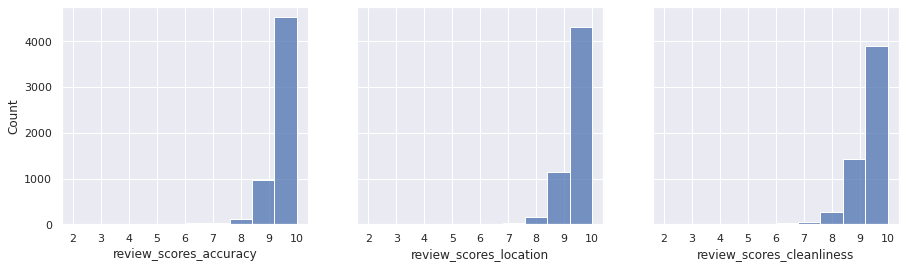

In [108]:
sns.set(rc={'figure.figsize':(15,4)})
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharey=True)
ax1.set(xticks=[1,2,3,4,5,6,7,8,9,10])
ax2.set(xticks=[1,2,3,4,5,6,7,8,9,10])
ax3.set(xticks=[1,2,3,4,5,6,7,8,9,10])
sns.histplot(x=listing_df.review_scores_accuracy,ax=ax1, bins=10)
sns.histplot(x=listing_df.review_scores_location,ax=ax2, bins=10)
sns.histplot(x=listing_df.review_scores_cleanliness,ax=ax3, bins=10)

<AxesSubplot:xlabel='review_scores_communication', ylabel='Count'>

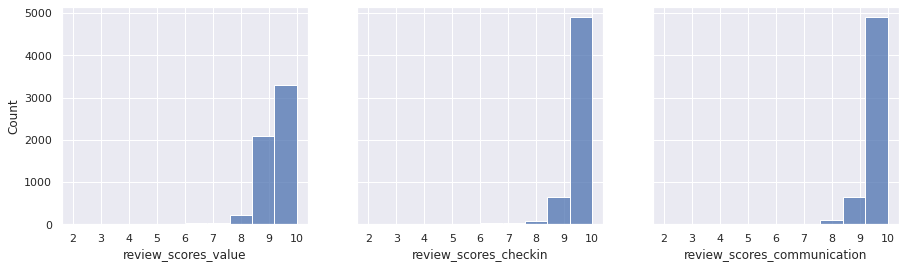

In [109]:
sns.set(rc={'figure.figsize':(15,4)})
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharey=True)
ax1.set(xticks=[1,2,3,4,5,6,7,8,9,10])
ax2.set(xticks=[1,2,3,4,5,6,7,8,9,10])
ax3.set(xticks=[1,2,3,4,5,6,7,8,9,10])
sns.histplot(x=listing_df.review_scores_value,ax=ax1, bins=10)
sns.histplot(x=listing_df.review_scores_checkin,ax=ax2, bins=10)
sns.histplot(x=listing_df.review_scores_communication,ax=ax3, bins=10)